# Overview of triangulation precision dependencies

This research is a part of project "Handy" that is conducted by HSE Robotics Groups.
The aims of this research are the following:
- to determine the best placement of cameras around the table
- to measure precision fluctuations caused by various center-determing algorithms, segmentation errors and FOV

Let us assume that intrinsic parameters of the cameras are known to us with ideal precision. Also, cameras' positions relative to each other 
(parameters of stereo calibration) are also known with maximum precision.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.transform import Rotation
from scipy.ndimage import center_of_mass

from typing import Tuple, List

In [13]:
# let us introduce intrinsic parameters and assume that they provide zero reprojection error for an arbitrary image-world correlation

IMAGE_SIZE = (1200, 1920)
K_1 = np.array(
    [
        672.2824725267757,
        0,
        984.0472159818853,
        0,
        672.6886411532304,
        602.96669930345,
        0,
        0,
        1,
    ]
).reshape((3, 3))
distortion_coefs_1 = np.array(
    [
        -0.09715103386082896,
        0.06788948036532018,
        -0.0007157453506997161,
        0.0003048354358359307,
        -0.003636308978789861,
    ]
)
K_2 = np.array(
    [
        685.7143789189881,
        0,
        991.0247637161314,
        0,
        686.3020333004097,
        601.2442243349392,
        0,
        0,
        1,
    ]
).reshape((3, 3))
distortion_coefs_2 = np.array(
    [
        -0.09781628655937251,
        0.07153618281495966,
        -0.001066517414175782,
        0.0004679942401339674,
        -0.003645360450147547,
    ]
)
# reference:
# https://github.com/robotics-laboratory/handy/blob/table-dataset-1/datasets/TableOrange2msRecord_22_04/camera_params.yaml
stereo_cam_rotation = [0.01175419895518242, 2.170836441913732, 2.19333242876324]
stereo_cam_translation = [-0.06677747450343367, -1.174973690204363, 1.140354306665756]

# other constant and measurements
TABLE_LENGTH = 2.74
TABLE_WIDTH = 1.525

In [14]:
inv = np.linalg.inv(K_1)
# x, y = 
# point = np.array([IMAGE_SIZE[0], IMAGE_SIZE[1], 1])
# point[0]
print(inv @ np.array([IMAGE_SIZE[1]/2, IMAGE_SIZE[0]/2, 1]).reshape((3, 1)))
print(K_1 @ np.array([1, 0, 1]).reshape((3, 1)))




[[-0.03576951]
 [-0.00441021]
 [ 1.        ]]
[[1.65632969e+03]
 [6.02966699e+02]
 [1.00000000e+00]]


In [15]:
from typing import Any


class Transformation:
    def __init__(self, R, t):
        self.R = R
        self.t = t.reshape((3, 1))
        self.R_inv = np.linalg.inv(self.R)

    def __call__(self, point):
        return self.R @ point + self.t
    
    def __mul__(self, other):
        return Transformation(self.R @ other.R, self.R @ other.t + self.t)

    def transform(self, point):
        return self(point)

    def inverse_transform(self, point):
        return self.R_inv @ (point - self.t)

    # right transformation is applied first
    def __mult__(self, other):
        return Transformation(self.R @ other.R, self.t + other.t)
    

class Image:
    def __init__(self, camera_matrix, camera_transformation, distortion_coefs, image_size=IMAGE_SIZE):
        self.camera_matrix = camera_matrix
        self.camera_transformation = camera_transformation
        self.distortion_coefs = distortion_coefs
        self.image_size = image_size

    def normilise_image_point(self, point):
        x_normalised = (point[0] - self.camera_matrix[0, 2]) / self.camera_matrix[0, 0]
        y_normalised = (point[1] - self.camera_matrix[1, 2]) / self.camera_matrix[1, 1]
        return np.array([x_normalised, y_normalised, 1]).reshape(3, 1)

    # in world coordinates
    def project_point_to_image(self, point):
        if point.shape != (3, 1):
            point = point.reshape((3, 1))
        return self.camera_matrix @ self.camera_transformation(point)

        # transformed_point = self.camera_transformation(point)
        # # transformed_point = transformed_point / transformed_point[2]
        # projected_point = self.camera_matrix @ transformed_point
        # return projected_point
    
    def project_points_to_image(self, points):
        return np.array([self.project_point_to_image(point) for point in points])
    
    def normilize_image_point(self, image_point):
        x_normalised = (image_point[0] - self.camera_matrix[0, 2]) / self.camera_matrix[0, 0]
        y_normalised = (image_point[1] - self.camera_matrix[1, 2]) / self.camera_matrix[1, 1]
        return np.array([x_normalised, y_normalised, 1]).reshape(3, 1)
        

    def project_ball_to_image(self, 
        center, radius: float) -> np.ndarray:

        def valid_coords(x, y):
            return x >= 0 and x < self.image_size[1] and y >= 0 and y < self.image_size[0]

        center = center.reshape((3, 1))
        camera_matrix_inv = np.linalg.inv(self.camera_matrix)

        transformed_center = self.camera_transformation(center)
        projected_center = self.camera_matrix @ transformed_center
        projected_center /= projected_center[2]

        if np.linalg.norm(projected_center.flatten() - np.array([IMAGE_SIZE[1]/2, IMAGE_SIZE[0]/2, 1])) > 2000:
            return np.zeros(self.image_size)

        image = np.zeros(self.image_size)
        checked_pixels = set()

        pixels_to_check = {(int(projected_center[0][0]), int(projected_center[1][0]))}
        while pixels_to_check:
            x, y = pixels_to_check.pop()

            image_point_camera_ray = camera_matrix_inv @ np.array([x, y, 1]).reshape((3, 1))
            image_point_world_ray = self.camera_transformation.inverse_transform(image_point_camera_ray) - \
                        self.camera_transformation.inverse_transform(np.array([0, 0, 0]).reshape((3, 1)))
            ball_center_world_ray = center - self.camera_transformation.inverse_transform(np.array([0, 0, 0]).reshape((3, 1)))

            distance = np.linalg.norm(
                np.cross(ball_center_world_ray.flatten(), image_point_world_ray.flatten()), ord=2) / \
                np.linalg.norm(image_point_world_ray, ord=2)
            if distance <= radius:
                if valid_coords(x, y):
                    image[y, x] = 1
                # adding all 8 neighbours to the queue
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        if (x + dx, y + dy) not in checked_pixels:
                            pixels_to_check.add((x + dx, y + dy))
                            checked_pixels.add((x + dx, y + dy))

        return image



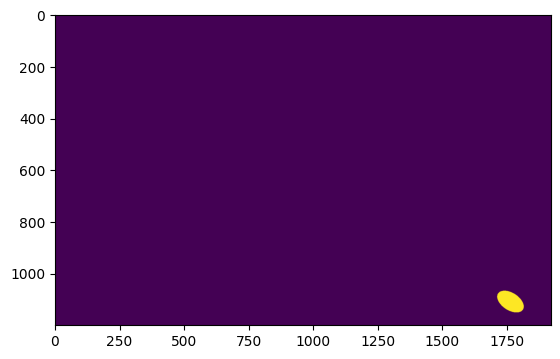

In [16]:
image = Image(K_1, Transformation(np.eye(3), np.zeros((3, 1))), distortion_coefs_1)
projected_ball_mask = image.project_ball_to_image(np.array([2.3, 1.5, 2]).reshape((3, 1)), 0.1)
plt.imshow(projected_ball_mask)

Visually testing `Image` class

In [17]:
import plotly.graph_objects as go
import numpy as np


def display_ball(position, radius, color):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = position[0] + radius * np.cos(u) * np.sin(v)
    y = position[1] + radius * np.sin(u) * np.sin(v)
    z = position[2] + radius * np.cos(v)
    
    return go.Surface(x=x, y=y, z=z, colorscale=[[0, color], [1, color]], showscale=False)

def display_camera(position, 3d_rotation_matrix, color="red", length=0.1):
    pass


def display_table(length, width):
    corners = np.array([
        [-length / 2, -width / 2],
        [length / 2, -width / 2],
        [length / 2, width / 2],
        [-length / 2, width / 2],
        [-length / 2, -width / 2]])


    return go.Surface(
        x=[[0, length, length, 0]],
        y=[[0, 0, width, width]],
        z=[[0, 0, 0, 0]],
        colorscale=[[0, 'brown'], [1, 'brown']],
        showscale=False
    )


def get_bbox(mask: np.ndarray) -> List[float]:
    if not np.any(mask):
        return [0., 0., 0., 0.]
    # x_min, y_min, x_max, y_max
    horizontal_indicies = np.where(np.any(mask, axis=0))[0]
    vertical_indicies = np.where(np.any(mask, axis=1))[0]
    x1, x2 = horizontal_indicies[[0, -1]]
    y1, y2 = vertical_indicies[[0, -1]]
    bbox = list(map(float, [x1, y1, x2, y2]))
    return bbox


def get_mask_center(mask):
    bbox = get_bbox(mask)
    centroid_x = (bbox[0] + bbox[2]) / 2
    centroid_y = (bbox[1] + bbox[3]) / 2
    return np.array([centroid_x, centroid_y])


def get_mask_centroid(mask):
    return np.array(center_of_mass(mask))



In [22]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px


class StereoScene:
    def __init__(self, left_camera: Image, right_camera: Image, table_middle_normal):
        self.left_camera = left_camera
        self.right_camera = right_camera
        self.table_middle_normal = table_middle_normal
        self.last_n_clicks = 0

    def project_ball_to_images(self, center, radius):
        left_image = self.left_camera.project_ball_to_image(center, radius)
        right_image = self.right_camera.project_ball_to_image(center, radius)
        return left_image, right_image
    
    def launch_3D_scene(self):
        app = dash.Dash(__name__)

        app.layout = html.Div([
            dcc.Graph(id='3d-scene'),
            dcc.Graph(id='left-image'),
            dcc.Graph(id='right-image'),
            html.Label('Ball X Position'),
            dcc.Slider(id='ball-x', min=-1.5, max=1.5, step=0.1, value=0.13),
            html.Label('Ball Y Position'),
            dcc.Slider(id='ball-y', min=-1.5, max=1.5, step=0.1, value=0),
            html.Label('Ball Z Position'),
            dcc.Slider(id='ball-z', min=0, max=2, step=0.1, value=1),
            html.Label('Master camera pitch'),
            dcc.Input(id='pitch_1', type='range'),
            html.Label('Master camera yaw'),
            dcc.Input(id='yaw_1', type='range'),
            html.Label('Master camera roll'),
            dcc.Input(id='roll_1', type='range'),
            html.Label('Slave camera pitch'),
            dcc.Input(id='pitch_2', type='range'),
            html.Label('Slave camera pitch'),
            dcc.Input(id='yaw_2', type='range'),
            html.Label('Slave camera pitch'),
            dcc.Input(id='roll_2', type='range'),
            html.Button('Evaluate camera placement', id='evaluate-placement'),
        ])

        @app.callback(
            [Output('3d-scene', 'figure'),
             Output('left-image', 'figure'),
             Output('right-image', 'figure')],
            [Input('ball-x', 'value'),
             Input('ball-y', 'value'),
             Input('ball-z', 'value'),
             Input('evaluate-placement', 'n_clicks')]
        )
        def update_scene(ball_x, ball_y, ball_z, n_clicks):
            ball_center = np.array([ball_x, ball_y, ball_z]).reshape((3, 1))
            left_image, right_image = self.project_ball_to_images(ball_center, 0.04)
            
            fig_3d = go.Figure(layout=go.Layout(
                                scene=dict(
                                aspectmode='data')))
            # fig_3d.add_trace(display_plane((0, 0, 1), (TABLE_LENGTH, TABLE_WIDTH), (0, 0, 0)))
            fig_3d.add_trace(display_ball((ball_x, ball_y, ball_z), 0.04, "green"))

            fig_3d.add_trace(go.Cone(x=[0], y=[0], z=[0], u=[0], v=[0], w=[-1], colorscale=[[0, "red"], [1, "red"]]))

            second_camera_direction = self.right_camera.camera_transformation.R @ np.array([0, 0, 1]).reshape((3, 1))
            second_cam_cone_position_direction = dict(zip(["x", "y", "z", "u", "v", "w"], 
                                                          [*self.right_camera.camera_transformation.t.tolist()] + 
                                                          [*(-second_camera_direction).tolist()]))
            fig_3d.add_trace(go.Cone(**second_cam_cone_position_direction,
                                     colorscale=[[0, "blue"], [1, "blue"]]))
            
            display_arrow([0, 0, 0], [1, 0, 0], "red", figure=fig_3d, length=10)

            fig_left = go.Figure(data=go.Heatmap(z=left_image),
                                 layout=go.Layout(
                                scene=dict(
                                aspectmode='data')))
            fig_right = go.Figure(data=go.Heatmap(z=right_image),
                                  layout=go.Layout(
                                scene=dict(
                                aspectmode='data')))

            center_1 = get_mask_center(left_image)
            center_2 = get_mask_center(right_image)
            points_1 = np.array([[center_1[0]], [center_1[1]]])
            points_2 = np.array([[center_2[0]], [center_2[1]]])
            print(self.triangulate_position(points_1, points_2,
                                            self.left_camera.camera_transformation, self.right_camera.camera_transformation))
            
            if self.last_n_clicks != n_clicks:
                self.last_n_clicks = n_clicks
                print("Evaluating camera placement")
            
            return fig_3d, fig_left, fig_right

        return app

    def triangulate_position(self, 
    points_by_view_1, points_by_view_2, world2cam, cam2cam
):
        print("triangulating")
        # print(points_by_view)
        world2cam_Rt = np.column_stack((world2cam.R, world2cam.t))
        world2second_cam = cam2cam * world2cam
        world2second_cam_Rt = np.column_stack((world2second_cam.R, world2second_cam.t))
        proj_1 = self.left_camera.camera_matrix @ world2cam_Rt
        proj_2 = self.right_camera.camera_matrix @ world2second_cam_Rt

        res = cv2.triangulatePoints(
            proj_1, proj_2, points_by_view_1, points_by_view_2
        )
        res /= res[3, :] # normalizing

        # TODO preserve 4D points?
        return res[:3, :]

In [23]:
camera_1_transform = Transformation(np.eye(3), np.array([0, 0, 0]))
image_1 = Image(K_1, camera_1_transform, distortion_coefs_1)
camera_2_transform = Transformation(cv2.Rodrigues(np.array(stereo_cam_rotation))[0], 
                                    np.array(stereo_cam_translation))
image_2 = Image(K_2, camera_2_transform, distortion_coefs_2)

scene = StereoScene(image_1, image_2, None)
app = scene.launch_3D_scene()
app.run_server(host="localhost", port="8060",
               debug=True, use_reloader=False)

triangulating
[[1.30151015e-01]
 [4.40582071e-05]
 [1.00013910e+00]]
Evaluating camera placement
triangulating
[[1.30151015e-01]
 [4.40582071e-05]
 [1.00013910e+00]]


[Ссылка на веб интерфейс для визуального контроля](http://localhost:8060)

In [62]:
def evaluate_camera_position(
    world2master: Transformation,
    master2second: Transformation,
    center_extractor,
    camera_matrix_1,
    camera_matrix_2,
):
    NUMBER_OF_SPHERES = 6

    image_1 = Image(K_1, world2master, distortion_coefs_1)
    image_2 = Image(K_2, master2second * world2master, distortion_coefs_2)
    stereo_scene = StereoScene(image_1, image_2, None)

    sphere_centers = []
    for x in np.linspace(-TABLE_LENGTH / 2, TABLE_LENGTH / 2, NUMBER_OF_SPHERES):
        for y in np.linspace(-TABLE_WIDTH / 2, TABLE_WIDTH / 2, NUMBER_OF_SPHERES):
            for z in np.linspace(0, 1, NUMBER_OF_SPHERES):
                sphere_centers.append((x, y, z))

    sphere_centers = np.array(sphere_centers).T
    points_1 = []
    points_2 = []
    valid_sphere_centers = []
    world2second = master2second * world2master

    for i in range(sphere_centers.shape[1]):    
        mask_1, mask_2 = stereo_scene.project_ball_to_images(
            sphere_centers[:, i : (i + 1)], 0.02
        )

        if np.sum(mask_1) == 0 or np.sum(mask_2) == 0:
            continue

        points_1.append(center_extractor(mask_1))
        points_2.append(center_extractor(mask_2))
        valid_sphere_centers.append(sphere_centers[:, i])

    points_1 = np.array(points_1).T
    points_2 = np.array(points_2).T
    sphere_centers = np.array(valid_sphere_centers).T
    print(sphere_centers.shape)

    triangulated_points = stereo_scene.triangulate_position(points_1, points_2, world2master, master2second)


    # Calculate the Euclidean distance between the true and triangulated points
    distances = np.linalg.norm(sphere_centers - triangulated_points, axis=0)
    
    # Calculate mean and standard deviation of the distances
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    
    print(f"Mean distance error: {mean_distance}")
    print(f"Standard deviation of distance error: {std_distance}")
    print("evalution complete")
    print()


In [65]:
# main test: opposite camera placement
# world2master = Transformation(Rotation.from_euler("xyz", [0, -45, -90], degrees=True).as_matrix(), np.array([-TABLE_LENGTH/4, TABLE_WIDTH, 0.5]))
# master2second = Transformation(Rotation.from_euler("xyz", [], degrees=True).as_matrix(), np.array([0, 0, 0]))

world2master = Transformation(
    Rotation.from_euler("xyz", [0, -45, -90], degrees=True).as_matrix(),
    np.array([-TABLE_LENGTH / 4, TABLE_WIDTH, 0.5]),
)
master2second = Transformation(
    cv2.Rodrigues(np.array(stereo_cam_rotation))[0], np.array(stereo_cam_translation))
evaluate_camera_position(world2master, master2second, get_mask_center, K_1, K_2)

(3, 54)
triangulating
Mean distance error: 0.005709064422212816
Standard deviation of distance error: 0.008145795684027528
evalution complete



In [ ]:
world2master = Transformation(
    Rotation.from_euler("xyz", [0, -45, -90], degrees=True).as_matrix(),
    np.array([-TABLE_LENGTH / 4, TABLE_WIDTH, 0.5]),
)
master2second = Transformation(
    cv2.Rodrigues(np.array(stereo_cam_rotation))[0], np.array(stereo_cam_translation))
evaluate_camera_position(world2master, master2second, get_mask_center, K_1, K_2)